### Analysis of Hacker News Posts

Hacker News is a site founded by Y Combinator. User-submitted posts receive votes and comments, similar to Reddit. This notebook analyzes a subset of Hacker News posts, using a [dataset from kaggle](https://www.kaggle.com/hacker-news/hacker-news-posts). This dataset contains about 20,000 rows, and is a small subset of all Hacker News posts. The dataset was generated on September 26, 2016.

#### Dataset Columns:

- `id`: the unique identifier from Hacker News for the post
- `title`: the title of the post
- `url`: the URL that the posts links to, if the post has a URL
- `num_points`: the number of points the post acquired, calculated as the total number of upvotes minus the total number of downvotes
- `num_comments`: the number of comments on the post
- `author`: the username of the person who submitted the post
- `created_at`: the date and time of the post's submission

#### Analysis Goals:

In this notebook, I use only the `csv` library and built-in Python tools to analyze data on Hacker News posts. I will answer questions like: "Does posting at a certain time garner more comments or likes?" and "Do `Ask HN` or `Show HN` posts tend to garner more comments or likes, on average?".

##### Import Packages

In [66]:
from csv import reader
import requests
import datetime as dt
import matplotlib.pyplot as plt

##### Read File

In [6]:
# The dataset is 20 Mb. I found the dataset on GitHub, and am using requests.get() to retrieve it.
url = 'https://github.com/michnapiotr/Guided-Project-Exploring-Hacker-News-Posts/blob/master/hacker_news_data.csv?raw=true'

In [15]:
retrieved_file = requests.get(url).content.decode('utf-8')

In [18]:
read_file = reader(retrieved_file.splitlines(), delimiter=',')
hn = list(read_file)

In [20]:
hn[:2]

[['id', 'title', 'url', 'num_points', 'num_comments', 'author', 'created_at'],
 ['12224879',
  'Interactive Dynamic Video',
  'http://www.interactivedynamicvideo.com/',
  '386',
  '52',
  'ne0phyte',
  '8/4/2016 11:52']]

We are only interested in the data rows, and won't need the header yet.

In [21]:
headers, hn = hn[0], hn[1:]

In [22]:
headers

['id', 'title', 'url', 'num_points', 'num_comments', 'author', 'created_at']

In [24]:
hn[:5]

[['12224879',
  'Interactive Dynamic Video',
  'http://www.interactivedynamicvideo.com/',
  '386',
  '52',
  'ne0phyte',
  '8/4/2016 11:52'],
 ['10975351',
  'How to Use Open Source and Shut the Fuck Up at the Same Time',
  'http://hueniverse.com/2016/01/26/how-to-use-open-source-and-shut-the-fuck-up-at-the-same-time/',
  '39',
  '10',
  'josep2',
  '1/26/2016 19:30'],
 ['11964716',
  "Florida DJs May Face Felony for April Fools' Water Joke",
  'http://www.thewire.com/entertainment/2013/04/florida-djs-april-fools-water-joke/63798/',
  '2',
  '1',
  'vezycash',
  '6/23/2016 22:20'],
 ['11919867',
  'Technology ventures: From Idea to Enterprise',
  'https://www.amazon.com/Technology-Ventures-Enterprise-Thomas-Byers/dp/0073523429',
  '3',
  '1',
  'hswarna',
  '6/17/2016 0:01'],
 ['10301696',
  'Note by Note: The Making of Steinway L1037 (2007)',
  'http://www.nytimes.com/2007/11/07/movies/07stein.html?_r=0',
  '8',
  '2',
  'walterbell',
  '9/30/2015 4:12']]

##### Filter Data

In [25]:
ask_posts = []
show_posts = []
other_posts = []
for row in hn:
    title = row[1]
    if title.lower().startswith('ask hn'):
        ask_posts.append(row)
    elif title.lower().startswith('show hn'):
        show_posts.append(row)
    else:
        other_posts.append(row)
print(f"There are {len(ask_posts)} Ask Posts, {len(show_posts)} Show Posts, and {len(other_posts)} Other Posts.")

There are 1744 Ask Posts, 1162 Show Posts, and 17196 Other Posts.


In [33]:
print(ask_posts[0])
print(show_posts[0])
print(other_posts[0])

['12296411', 'Ask HN: How to improve my personal website?', '', '2', '6', 'ahmedbaracat', '8/16/2016 9:55']
['10627194', 'Show HN: Wio Link  ESP8266 Based Web of Things Hardware Development Platform', 'https://iot.seeed.cc', '26', '22', 'kfihihc', '11/25/2015 14:03']
['12224879', 'Interactive Dynamic Video', 'http://www.interactivedynamicvideo.com/', '386', '52', 'ne0phyte', '8/4/2016 11:52']


##### Which type of post receives more comments, on average?

In [29]:
total_ask_comments = 0 #comments is index no. 4 in dataset
for row in ask_posts:
    no_comments = int(row[4])
    total_ask_comments += no_comments

avg_ask_comments = total_ask_comments / len(ask_posts)
print(f"Average number of comments on Ask Posts: {avg_ask_comments}")

Average number of comments on Ask Posts: 14.038417431192661


In [31]:
total_show_comments = 0 #comments is index no. 4 in dataset
for row in show_posts:
    no_comments = int(row[4])
    total_show_comments += no_comments

avg_show_comments = total_show_comments / len(show_posts)
print(f"Average number of comments on Show Posts: {avg_show_comments}")

Average number of comments on Show Posts: 10.31669535283993


It appears that `Ask HN` posts receive more comments than `Show HN` posts, on average.

##### Which time garners most attention for `Ask HN` posts?

Two steps:
- Calculate the number of `Ask HN` posts for each hour of the day, along with number of comments received.
- Calculate the average number of comments -- or points -- received on posts at each hour of the day.
- Plot the data.

In our dataset, dates and times for each post are in the format `'9/30/2015 4:12'`; stored in row index 6.

In [38]:
datetime_template = '%m/%d/%Y %H:%M'

In [36]:
result_list = []
for row in ask_posts:
    created_at = row[6]
    no_comments = int(row[4])
    result_list.append([created_at, no_comments])

In [43]:
counts_by_hour = {}
comments_by_hour = {}

for row in result_list:
    hour = row[0]
    no_comments = row[1]
    hour_object = dt.datetime.strptime(hour, datetime_template)
    actual_hour = hour_object.strftime('%H')
    
    if actual_hour in counts_by_hour:
        counts_by_hour[actual_hour] += 1
        comments_by_hour[actual_hour] += no_comments
    else:
        counts_by_hour[actual_hour] = 1
        comments_by_hour[actual_hour] = no_comments

In [45]:
counts_by_hour #Number of Ask Posts created during each hour of the day.

{'09': 45,
 '13': 85,
 '10': 59,
 '14': 107,
 '16': 108,
 '23': 68,
 '12': 73,
 '17': 100,
 '15': 116,
 '21': 109,
 '20': 80,
 '02': 58,
 '18': 109,
 '03': 54,
 '05': 46,
 '19': 110,
 '01': 60,
 '22': 71,
 '08': 48,
 '04': 47,
 '00': 55,
 '06': 44,
 '07': 34,
 '11': 58}

In [47]:
comments_by_hour #Number of comments (total, not average) for Ask Posts created during each hour of the day

{'09': 251,
 '13': 1253,
 '10': 793,
 '14': 1416,
 '16': 1814,
 '23': 543,
 '12': 687,
 '17': 1146,
 '15': 4477,
 '21': 1745,
 '20': 1722,
 '02': 1381,
 '18': 1439,
 '03': 421,
 '05': 464,
 '19': 1188,
 '01': 683,
 '22': 479,
 '08': 492,
 '04': 337,
 '00': 447,
 '06': 397,
 '07': 267,
 '11': 641}

##### Calculating average comments per post per hour

In [68]:
avg_comments_by_hour = []

for hour in comments_by_hour:
    for time in counts_by_hour:
        if hour == time:
            avg_comments_by_hour.append([int(hour), comments_by_hour[hour] / counts_by_hour[time]]) # comments_by_hour / counts_by_hour

In [69]:
avg_comments_by_hour

[[9, 5.5777777777777775],
 [13, 14.741176470588234],
 [10, 13.440677966101696],
 [14, 13.233644859813085],
 [16, 16.796296296296298],
 [23, 7.985294117647059],
 [12, 9.41095890410959],
 [17, 11.46],
 [15, 38.5948275862069],
 [21, 16.009174311926607],
 [20, 21.525],
 [2, 23.810344827586206],
 [18, 13.20183486238532],
 [3, 7.796296296296297],
 [5, 10.08695652173913],
 [19, 10.8],
 [1, 11.383333333333333],
 [22, 6.746478873239437],
 [8, 10.25],
 [4, 7.170212765957447],
 [0, 8.127272727272727],
 [6, 9.022727272727273],
 [7, 7.852941176470588],
 [11, 11.051724137931034]]

In [70]:
sorted_avg_comments_by_hour = sorted(avg_comments_by_hour)

We'd like to sort the data based on the average number of comments received for each hour. Unfortunately, using sort() on this list-of-lists would only sort the hours, which are currently strings. To sort the data, we'll first need to invert the list of lists, and then used sorted().

In [61]:
swap_avg_by_hour = []
for row in avg_comments_by_hour:
    swap_avg_by_hour.append([row[1], int(row[0])])
print(swap_avg_by_hour)

[[5.5777777777777775, 9], [14.741176470588234, 13], [13.440677966101696, 10], [13.233644859813085, 14], [16.796296296296298, 16], [7.985294117647059, 23], [9.41095890410959, 12], [11.46, 17], [38.5948275862069, 15], [16.009174311926607, 21], [21.525, 20], [23.810344827586206, 2], [13.20183486238532, 18], [7.796296296296297, 3], [10.08695652173913, 5], [10.8, 19], [11.383333333333333, 1], [6.746478873239437, 22], [10.25, 8], [7.170212765957447, 4], [8.127272727272727, 0], [9.022727272727273, 6], [7.852941176470588, 7], [11.051724137931034, 11]]


In [62]:
sorted_swap = sorted(swap_avg_by_hour, reverse=True)

In [63]:
sorted_swap

[[38.5948275862069, 15],
 [23.810344827586206, 2],
 [21.525, 20],
 [16.796296296296298, 16],
 [16.009174311926607, 21],
 [14.741176470588234, 13],
 [13.440677966101696, 10],
 [13.233644859813085, 14],
 [13.20183486238532, 18],
 [11.46, 17],
 [11.383333333333333, 1],
 [11.051724137931034, 11],
 [10.8, 19],
 [10.25, 8],
 [10.08695652173913, 5],
 [9.41095890410959, 12],
 [9.022727272727273, 6],
 [8.127272727272727, 0],
 [7.985294117647059, 23],
 [7.852941176470588, 7],
 [7.796296296296297, 3],
 [7.170212765957447, 4],
 [6.746478873239437, 22],
 [5.5777777777777775, 9]]

##### Top 5 Hours for Ask Posts Comments

In [64]:
for row in sorted_swap[:5]:

    print(f"{row[1]} hours: {row[0]:.2f} average comments per post.")

15 hours: 38.59 average comments per post.
2 hours: 23.81 average comments per post.
20 hours: 21.52 average comments per post.
16 hours: 16.80 average comments per post.
21 hours: 16.01 average comments per post.


##### Simple Plot of the Data

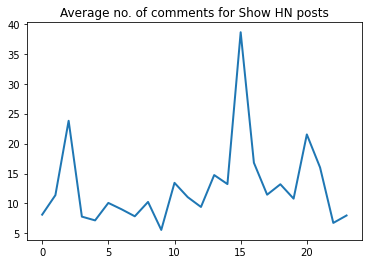

In [72]:
fig, ax = plt.subplots()
x = [i[0] for i in sorted_avg_comments_by_hour]
y = [i[1] for i in sorted_avg_comments_by_hour]

ax.plot(x, y, linewidth=2.0)
ax.set_title('Average no. of comments for Show HN posts')

plt.show()